# Map Data Cleansing and Conversion with MongoDB

### Table of Contents
1. Purpose
2. Data
3. Exploratory Analysis on XML
4. Problem Detection and Data Cleansing
5. Conversion from XML to JSON
6. Data in MongoDB
7. Summary
8. Future Projects
9. Reference

## 1. Purpose
The purpose of this project is to find quality issues in OSM ([OpenStreetMap](https://www.openstreetmap.org)) XML data specifically for Singapore and clean those up in programmatic ways. After the data cleansing it will be converted into a JSON file and registered in MongoDB to explore some basic aspects of the data. The data cleansing will be performed in a general sense and any specific data usage after the cleansing is not considered.

# 2. Data
The OSM XML data of Singapore is obtained from [Map Zen](https://mapzen.com/data/metro-extracts) which provides the latest OSM XML data of various locations predefined. 

[File name] singapore.osm  
[File size] 199 MB  
[Date file downloaded] Jan 9, 2016  
[Definition of OSM XML] http://wiki.openstreetmap.org/wiki/OSM_XML  

This XML file is loaded into Python as follows.

In [1]:
import xml.etree.cElementTree as ET

# Load XML data
tree = ET.parse("./input/singapore.osm")

## 3. Exploratory Analysis on XML
To understand the data structure let's shed light on it from several angles.  
First, how many tag are there?

In [2]:
from pprint import pprint

def count_tag(tree):
    """
    Count number of tags in xml.
    """
    tags = {}
    for e in tree.iter():
        if e.tag not in tags:
            tags[e.tag] = 1
        else:
            tags[e.tag] += 1
    return tags

pprint(count_tag(tree))

{'bounds': 1,
 'member': 69885,
 'nd': 1146529,
 'node': 931707,
 'osm': 1,
 'relation': 1762,
 'tag': 461958,
 'way': 139814}


How is it structured?

In [3]:
def check_structure(parent, element):
    """
    Recursively drill down an element passed and count all elements under the element.
    
    Args:
        parent: A list [int, dict] which indicates parent element count and child elements.
        element: An Element object of xml to be checked.
    Yields:
        A hierarchical list [int, dict] which expresses structure of the element.
        Note, the result will be directly reflected in "parent".
    """
    if parent[1].has_key(element.tag):
        parent[1][element.tag][0] += 1
    else:
        parent[1][element.tag] = [1, {}]
    for child in element:
        # Recursive call for children
        check_structure(parent[1][element.tag], child)

# Check structure of xml
structure = [1, {}]
check_structure(structure, tree.getroot())
pprint(structure)

[1,
 {'osm': [1,
          {'bounds': [1, {}],
           'node': [931707, {'tag': [80464, {}]}],
           'relation': [1762, {'member': [69885, {}], 'tag': [6191, {}]}],
           'way': [139814, {'nd': [1146529, {}], 'tag': [375303, {}]}]}]}]


It looks a simple structure. The *osm* is the root which have just four types of children and *bounds* is an unique child. The other three children *node*, *relation* and *way* have a few grandchildren and *tag* is common for all.  

I define this structure as a list of tag names. The list exclude the root and grandchildren are expressed with the parent name followed by slash.

In [4]:
# Tag names (exclude the root "osm")
TAGS = ["bounds",
        "node", "node/tag", \
        "relation", "relation/tag", "relation/member", \
        "way", "way/nd", "way/tag"]

Next, let's take a look at attributes of each tag.  

In [7]:
pprint(tree.getroot().attrib)

{'generator': 'osmconvert 0.7T',
 'timestamp': '2016-01-09T00:27:02Z',
 'version': '0.6'}


The root has just three attributes. The *timestamp* seems to be the date I downloaded the OSM XML file.  

For children and grandchildren I check number of attributes first since there might be inconsistencies of attributes.

In [6]:
def count_attributes(tree, tag):
    """
    Count total number of attributes in tag.
    """
    attributes = {}
    for element in tree.findall(tag):
        for attr in element.attrib.keys():
            if attr not in attributes:
                attributes[attr] = 1
            else:
                attributes[attr] += 1
    return attributes

# 
for tag in TAGS:
    print tag
    pprint(count_attributes(tree, tag))
    print ""

bounds
{'maxlat': 1, 'maxlon': 1, 'minlat': 1, 'minlon': 1}

node
{'changeset': 931707,
 'id': 931707,
 'lat': 931707,
 'lon': 931707,
 'timestamp': 931707,
 'uid': 931707,
 'user': 931707,
 'version': 931707}

node/tag
{'k': 80464, 'v': 80464}

relation
{'changeset': 1762,
 'id': 1762,
 'timestamp': 1762,
 'uid': 1762,
 'user': 1762,
 'version': 1762}

relation/tag
{'k': 6191, 'v': 6191}

relation/member
{'ref': 69885, 'role': 69885, 'type': 69885}

way
{'changeset': 139814,
 'id': 139814,
 'timestamp': 139814,
 'uid': 139814,
 'user': 139814,
 'version': 139814}

way/nd
{'ref': 1146529}

way/tag
{'k': 375303, 'v': 375303}



In spite of my worry, attributes are perfectly consistent in all tags. The number of each tag exactly matches the number of each attribute in the tag.  

So how does each tag actually look like? Let's see some examples.

In [8]:
def show_samples(tree, tags, n):
    """
    Show n sample elements of specified tags.
    """
    for tag in tags:
        print tag
        for element in tree.findall(tag)[:n]:
            pprint(element.attrib)
        print ""

show_samples(tree, TAGS, 3)

bounds
{'maxlat': '1.823',
 'maxlon': '104.545',
 'minlat': '0.807',
 'minlon': '103.062'}

node
{'changeset': '11813456',
 'id': '25451905',
 'lat': '1.3506426',
 'lon': '103.9858325',
 'timestamp': '2012-06-06T08:22:22Z',
 'uid': '602634',
 'user': 'matx17',
 'version': '5'}
{'changeset': '12722335',
 'id': '25451906',
 'lat': '1.2949801',
 'lon': '103.8699726',
 'timestamp': '2012-08-14T05:24:20Z',
 'uid': '602634',
 'user': 'matx17',
 'version': '8'}
{'changeset': '7236325',
 'id': '25451907',
 'lat': '1.3415164',
 'lon': '103.9819841',
 'timestamp': '2011-02-09T14:34:13Z',
 'uid': '378414',
 'user': 'jaredc',
 'version': '4'}

node/tag
{'k': 'ref', 'v': '2A'}
{'k': 'highway', 'v': 'motorway_junction'}
{'k': 'created_by', 'v': 'JOSM'}

relation
{'changeset': '10451285',
 'id': '208077',
 'timestamp': '2012-01-20T22:19:39Z',
 'uid': '255802',
 'user': 'cboothroyd',
 'version': '2'}
{'changeset': '36275474',
 'id': '228097',
 'timestamp': '2015-12-31T03:46:24Z',
 'uid': '2254599',
 '

What's notable is that *tag* elements have a pair attribute *k*(ey)-*v*(alue) which expresses an arbitrary value for an arbitrary key. This feels a bit challenging from a data cleansing perspective.  

Anyway, for now let's define data type for each attribute based on the sample information. Note, at this moment it's just my guess and will be confirmed later on.

In [9]:
from datetime import datetime

# Data type of attributes
DTYPE = {
    "bounds"          : {'maxlat'   : float,
                         'maxlon'   : float,
                         'minlat'   : float,
                         'minlon'   : float},
    "node"            : {'changeset': int,
                         'id'       : int,
                         'lat'      : float,
                         'lon'      : float,
                         'timestamp': datetime,
                         'uid'      : int,
                         'user'     : str,
                         'version'  : int}, 
    "node/tag"        : {'k'        : str, 
                         'v'        : str},
    "relation"        : {'changeset': int,
                         'id'       : int,
                         'timestamp': datetime,
                         'uid'      : int,
                         'user'     : str,
                         'version'  : int},
    "relation/tag"    : {'k'        : str, 
                         'v'        : str}, 
    "relation/member" : {'ref'      : int, 
                         'role'     : str, 
                         'type'     : str}, 
    "way"             : {'changeset': int,
                         'id'       : int,
                         'timestamp': datetime,
                         'uid'      : int,
                         'user'     : str,
                         'version'  : int},  
    "way/nd"          : {'ref'      : int},
    "way/tag"         : {'k'        : str, 
                         'v'        : str}
}

## 4. Problem Detection and Data Cleansing
To get ideas how the data should be cleaned up, I'd like to drill down *tag* elements further. What k(ey)s do they actually have?

In [11]:
from pprint import pformat

def count_k(tag_elements):
    """
    Count value of "k(ey)" attribute in "*/tag" element.
    
    Args:
        tag_elements: */tag elements which have "k" attribute.
    Return:
        A list of tupples (count, k) in descending order of count.
    """
    count = {}
    for element in tag_elements:
        if count.has_key(element.get("k")):
            count[element.get("k")] += 1
        else:
            count[element.get("k")] = 1
    return sorted([(cnt, k) for (k, cnt) in count.items()], reverse=True)

# Count value of k(ey) in "*/tag"
with open('./output/node-tag.txt', 'w') as f:
    f.write(pformat(count_k(tree.findall("node/tag"))))
with open('./output/relation-tag.txt', 'w') as f:
    f.write(pformat(count_k(tree.findall("relation/tag"))))
with open('./output/way-tag.txt', 'w') as f:
    f.write(pformat(count_k(tree.findall("way/tag"))))

The output files obtained are the following. You can see the list of k(ey)s with their count.  

- [node-tag.txt](./output/node-tag.txt)
- [relation-tag.txt](./output/relation-tag.txt)
- [way-tag.txt](./output/way-tag.txt)

From these result, let's check v(alue)s of some top ranked k(ey)s. A key is specified as [@k=xxxxx] when the search is performed.

In [12]:
def count_v(tag_elements):
    """
    Count value of "v(alue)" attribute in "*/tag" element.
    
    Args:
        tag_elements: */tag elements which have "v" attribute.
    Return:
        A list of tupples (count, k) in descending order of count.
    """
    count = {}
    for element in tag_elements:
        if count.has_key(element.get("v")):
            count[element.get("v")] += 1
        else:
            count[element.get("v")] = 1
    return sorted([(cnt, v) for (v, cnt) in count.items()], reverse=True)

# Check some "v(alue)" in "node/tag"
with open('./output/node-tag@name.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='name']"))))
with open('./output/node-tag@highway.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='highway']"))))
with open('./output/node-tag@location.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='location']"))))
with open('./output/node-tag@amenity.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='amenity']"))))
with open('./output/node-tag@street.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='addr:street']"))))
with open('./output/node-tag@postcode.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='addr:postcode']"))))

# Check some "v(alue)" in "relation/tag"
with open('./output/relation-tag@type.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("relation/tag[@k='type']"))))
with open('./output/relation-tag@name.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("relation/tag[@k='name']"))))
with open('./output/relation-tag@route.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("relation/tag[@k='route']"))))

# Check some "v(alue)" in "way/tag"
with open('./output/way-tag@highway.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("way/tag[@k='highway']"))))
with open('./output/way-tag@name.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("way/tag[@k='name']"))))
with open('./output/way-tag@postcode.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("way/tag[@k='addr:postcode']"))))

Output files from the code above are as follows.  
[node/tag]
- [name](./output/node-tag@name.txt)
- [highway](./output/node-tag@highway.txt)
- [location](./output/node-tag@location.txt)
- [amenity](./output/node-tag@amenity.txt)
- [addr:street](./output/node-tag@street.txt)
- [addr:postcode](./output/node-tag@postcode.txt)

[relation/tag]
- [type](./output/relation-tag@type.txt)
- [name](./output/relation-tag@name.txt)
- [route](./output/relation-tag@route.txt)

[way/tag]
- [highway](./output/way-tag@highway.txt)
- [name](./output/way-tag@name.txt)
- [addr:postcode](./output/way-tag@postcode.txt)


By browsing these files, I noticed the following problems.  

In [*name*](./output/node-tag@name.txt) key of node/tag,  
**[Problem 1]** Some words do not start with capital latter while most of words do.  
**[Problem 2]** Inconsistent usage of common words' abbrebiation. Sometimes it's abbreviated, sometime it's not.    
        - Opp <-> Opposite  
        - Bef <-> Bofore  
        - Aft <-> After  
        - Blk <-> Block  
**[Problem 3]** Unstandardized franchised stores' name  
        - McDonald's -> McDonalds, Mcdonald's, McDonalds (24Hrs)  
        - 7-Eleven -> 7 Eleven, Seven Eleven 
        - Starbucks -> Starbucks Coffee  
        - MOS Burger -> Mos Burger  
        - Pizza Hut -> Pizza Hut (Delivery), Pizza Hut Express  

In *addr:postcode* key of both [node/tag](./output/node-tag@postcode.txt) and [way/tag](./output/way-tag@postcode.txt),  
**[Problem 4]** Alphabetical characters are included.  
**[Problem 5]** Some of them are not six digits. It should be six digits. [(Postal codes in Singapore)](https://en.wikipedia.org/wiki/Postal_codes_in_Singapore).  
**[Problem 6]** Some might not start with the predefined two digits which indicates districts. [(List of Postal Districts)](https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm)  

So those problems are cleaned up one by one.

**[Problem 1]** Some words do not start with capital latter while most of words do.

In [14]:
import re

# node/tag[@k='name']
node_tag_names = tree.findall("node/tag[@k='name']")
  
def capitalize_head(tag_elements):
    """
    Capitalizes head of each word in "v(alue)" of */tag elements.
    Ignores common prepositions. (of, at, on, in, by, to, for, and, the)
    
    Args:
        tag_elements: A list of */tag elements.
    Yields:
        The change is directly reflected in xml elements.
    Returns:
        A list of tuples (before, after).
    """
    lower_head = re.compile(r'^[a-z]| [a-z]')
    ignored = re.compile(r'of |at |on |in |by |to |for |and |the ')
    modified = []
    for element in tag_elements:
        bef = element.get("v")
        while ignored.search(bef) is not None:
            bef = ignored.sub('', bef)
        if lower_head.search(bef):
            bef = element.get("v")
            aft = ''
            for word in bef.split(' '):
                if word in ('of', 'at', 'on', 'in', 'by', 'to', 'for', 'and', 'the'):
                    aft += word + ' '
                else:
                    aft += word[0].capitalize() + word[1:] + ' '
            element.set("v", aft.rstrip())
            modified.append((bef, aft.rstrip()))
    return modified

# Capitalizes head of each word in name
with open('./output/node-tag@name-capitalized.txt', 'w') as f:
    f.write(pformat(capitalize_head(node_tag_names)))

In the log file [name-capitalized.txt](./output/node-tag@name-capitalized.txt), you can see what values are changed and how.

**[Problem 2]** Inconsistent usage of common words' abbrebiation. Sometimes it's abbreviated, sometime it's not.

In [15]:
def standardize_name(tag_elements, target_exp, standardized):
    """
    Standardizes "v(alue)" of */tag elements.
    Changes values which correspond to a regular experssion target_exp.
    
    Args:
        tag_elements: A list of */tag elements.
        target_exp: A regular expression targetted. Case-insensitive.
        standardized: A standardized value converted into.
    Yields:
        The change is directly reflected in xml elements.
    Returns:
        A list of tuples (before, after).
    """
    target = re.compile(target_exp, re.IGNORECASE)
    modified = []
    for element in tag_elements:
        bef = element.get("v")
        if target.search(bef):
            aft = target.sub(standardized, bef)
            element.set("v", aft)
            modified.append((bef, aft))
    return modified

# Recover abbreviated words in name
with open('./output/node-tag@name-abbrev.txt', 'w') as f:
    f.write("'^blk ' -> 'Block '\n")
    f.write(pformat(standardize_name(node_tag_names, r"^blk ", "Block ")))
    f.write("\n\n' blk ' -> ' Block '\n")
    f.write(pformat(standardize_name(node_tag_names, r" blk ", " Block ")))
    f.write("\n\n'^opp ' -> 'Opposite '\n")
    f.write(pformat(standardize_name(node_tag_names, r"^opp ", "Opposite ")))
    f.write("\n\n' opp ' -> ' Opposite '\n")
    f.write(pformat(standardize_name(node_tag_names, r" opp ", " Opposite ")))
    f.write("\n\n'^bef ' -> 'Before '\n")
    f.write(pformat(standardize_name(node_tag_names, r"^bef ", "Before ")))
    f.write("\n\n' bef ' -> ' Before '\n")
    f.write(pformat(standardize_name(node_tag_names, r" bef ", " Before ")))
    f.write("\n\n'^aft ' -> 'After '\n")
    f.write(pformat(standardize_name(node_tag_names, r"^aft ", "After ")))
    f.write("\n\n' aft ' -> ' After '\n")
    f.write(pformat(standardize_name(node_tag_names, r" aft ", " After ")))

In the log file [name-abbrev.txt](./output/node-tag@name-abbrev.txt), you can see what values are changed and how.

**[Problem 3]** Unstandardized franchised stores' name

In [16]:
with open('./output/node-tag@name-franchise.txt', 'w') as f:
    f.write(pformat(standardize_name(node_tag_names, r"7.11|7.eleven|seven.11|seven.eleven", "7-Eleven")))
    f.write("\n\n")
    f.write(pformat(standardize_name(node_tag_names, r"starbucks coffee|starbucks", "Starbucks")))
    f.write("\n\n")
    f.write(pformat(standardize_name(node_tag_names, r"mcdonald.s .+|mcdonalds .+|mcdonald.s|mcdonalds", "McDonald's")))
    f.write("\n\n")
    f.write(pformat(standardize_name(node_tag_names, r"mos.burger", "MOS Burger")))
    f.write("\n\n")
    f.write(pformat(standardize_name(node_tag_names, r"pizza.hut .+|pizza.hut", "Pizza Hut")))

In the log file [name-franchise.txt](./output/node-tag@name-franchise.txt), you can see what values are changed and how.

Now all three problems from *name* key in node/tag elements are cleaned up. So let's take the summary and compare it to the one before the change.

In [17]:
# Record node/tag[@k='name'] after change
with open('./output/node-tag@name_aft.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='name']"))))

If you compare the summary of [before](./output/node-tag@name.txt) and [after](./output/node-tag@name_aft.txt), it's clear that the modifications intended are done.

**[Problem 4]** Alphabetical characters are included.

In [18]:
def remove_non_numeric(tag_elements):
    """
    Removes non-numerical characters in "v(alue)" of */tag elements.
    
    Args:
        tag_elements: A list of */tag elements.
    Yields:
        The change is directly reflected in xml elements.
    Returns:
        A list of tuples (before, after).
    """
    alpha = re.compile(r"[^0-9]")
    modified = []
    for element in tag_elements:
        bef = element.get("v")
        if alpha.search(bef):
            aft = alpha.sub("", bef)
            element.set("v", aft)
            modified.append((bef, aft))
    return modified

# Remove non-numeric characters in postcode
with open('./output/node-tag@postcode-alphabet.txt', 'w') as f:
    f.write(pformat(remove_non_numeric(tree.findall("node/tag[@k='addr:postcode']"))))
with open('./output/way-tag@postcode-alphabet.txt', 'w') as f:
    f.write(pformat(remove_non_numeric(tree.findall("way/tag[@k='addr:postcode']"))))

As always, the following are the log file of the change.  
    [node-tag@postcode-alphabet.txt](./output/node-tag@postcode-alphabet.txt)  
    [way-tag@postcode-alphabet.txt](./output/way-tag@postcode-alphabet.txt)  

**[Problem 5]** Some of them are not six digits. It should be six digits. [(Postal codes in Singapore)](https://en.wikipedia.org/wiki/Postal_codes_in_Singapore).  
**[Problem 6]** Some might not start with the predefined two digits which indicates districts. [(List of Postal Districts)](https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm)  

In [19]:
def remove_invalid_postcodes(parents):
    """
    Remove invalid postal code tag elements.
        Case 1: Not six digits.
        Case 2: Invalid first two digits.
                The first two digits should be between 01 to 82 except 74
    Args:
        parents: A list of parent elements that have postcode tag.
    Yields:
        Invalid postal code tag elements are removed from xml elements.
    Returns:
        A list of postal codes removed.
    """
    removed = []
    valid_codes = [str(i) for i in xrange(1, 83) if i != 74]
    valid_codes = ['0' + i if len(i) == 1 else i for i in valid_codes]
    for parent in parents:
        for tag in parent.findall("tag[@k='addr:postcode']"):
            postcode = tag.get("v")
            if postcode[:2] not in valid_codes:
                parent.remove(tag)
                removed.append(postcode)
                continue
            if len(postcode) != 6:
                parent.remove(tag)
                removed.append(postcode)
    
    return removed

# Remove invalid postal code tag elements
with open('./output/node-tag@postcode-invalid.txt', 'w') as f:
    f.write(pformat(remove_invalid_postcodes(tree.findall("node"))))
with open('./output/way-tag@postcode-invalid.txt', 'w') as f:
    f.write(pformat(remove_invalid_postcodes(tree.findall("way"))))

[node-tag@postcode-invalid.txt](./output/node-tag@postcode-invalid.txt)  
[way-tag@postcode-invalid.txt](./output/way-tag@postcode-invalid.txt)  

Problem 5 and 6 are handled at the same time.  
But after looking at the log file, I noticed that there is no ivalid postal code because of the first two digits. The problem 6 did not actually exist.

Now problem 4 to 6 that are related to postal code are cleaned up. So let's take the summary and compare it to the one before the change.

In [20]:
# Record [@k='addr:postcode'] after change
with open('./output/node-tag@postcode_aft.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("node/tag[@k='addr:postcode']"))))
with open('./output/way-tag@postcode_aft.txt', 'w') as f:
    f.write(pformat(count_v(tree.findall("way/tag[@k='addr:postcode']"))))

[node/tag[@k='addr:postcode']]  
    [Before](./output/node-tag@postcode.txt)  
    [After](./output/node-tag@postcode_aft.txt)  
[way/tag[@k='addr:postcode']]  
    [Before](./output/node-tag@postcode.txt)  
    [After](./output/node-tag@postcode_aft.txt)  

Now postal codes seem to be clean. What's a little worried is that there are more than 9000 invalid postal codes in *way/tag* though, they can be summarized in a limitted number of patterns. The most of them are five digits and start with "80" or "81". This feels that "0" might be just missing from the head of tail. But here I just removed them as invalide postal codes.

## 5. Conversion from XML to JSON
So let's convert the cleaned XML data into a JSON file as a preparation of data registration into MongoDB.  
To start the conversion, I first check the data type of each attribute which I guessed based on some sample data. In the following operation, data type conversion is performed according to the temporary definition and output an error message if a conversion cannot be done.

In [21]:
def error_msg(msg, tag, attr, val):
    """
    Prints error message.
    """
    print "[Error]" , msg, "\n", \
          "        Tag  :", tag, "\n", \
          "        Attr :", attr, "\n", \
          "        Value:",  val

def convert_dtype(tree, tags, dtype):
    """
    Converts string value of xml attributes into specified data type.
    
    Args:
        tree: An ElementTree object.
        tags: A list of tag name targetted for conversion.
        dtype: A dict of attribute's data type converted into.
    Yields:
        Attributes in tree are directly modified.
        In case there is an conversion error, an error message will be shown.
    """
    for tag in tags:
        elements = tree.findall(tag)
        for attr in dtype[tag].keys():
            for element in elements:
                if dtype[tag][attr] == int:
                    try:
                        element.set(attr, int(element.get(attr)))
                    except ValueError:
                        error_msg("Cannot convert into int.", tag, attr, element.get(attr))
                    
                elif dtype[tag][attr] == float:
                    try:
                        element.set(attr, float(element.get(attr)))
                    except ValueError:
                        error_msg("Cannot convert into float.", tag, attr, element.get(attr))
                    
                elif dtype[tag][attr] == datetime:
                    try:
                        element.set(attr, datetime.strptime(element.get(attr), \
                                                            '%Y-%m-%dT%H:%M:%SZ'))
                    except ValueError:
                        error_msg("Cannot convert into datetime.", tag, attr, element.get(attr))
                    
                else:
                    # Do nothing for str
                    None

# Execute data type conversion
convert_dtype(tree, TAGS, DTYPE)

Since no error message was shown, all data type conversions were properly done. My guess was actually correct.  

To create a JSON file, the XML object has to change into a dictionary-based data structure. In the following operation, the conversion and output to a file are performed element by element to save memory.

In [22]:
import json
from bson import json_util

def convert_xml_2_json(tree, filename):
    """
    Converts xml to json file.
    A field "xml" is added to record tag name.
    
    Args:
        tree: An ElementTree object.
        filename: A JSON file name outputted.
    Yields:
        A JSON file.
    """
    with open("./input/" + filename, "w") as f:
        # Start of JSON file
        f.write("[\n")
        
        # Convert the root element
        root = tree.getroot().attrib.copy()
        root["timestamp"] = datetime.strptime(root["timestamp"], '%Y-%m-%dT%H:%M:%SZ')
        root["xml"] = tree.getroot().tag
        json.dump(root, f, default=json_util.default, indent=4)
        
        # Convert all elements under the root
        for parent in tree.getroot():
            record = parent.attrib.copy()
            record["xml"] = parent.tag
            if parent.iter():
                if parent.tag == "node":
                    # "node/tag"
                    if parent.findall("tag"):
                        record["tag"] = []
                        for child in parent.findall("tag"):
                            record["tag"].append(child.attrib)
                
                elif parent.tag == "relation":
                    # "relation/tag"
                    if parent.findall("tag"):
                        record["tag"] = []
                        for child in parent.findall("tag"):
                            record["tag"].append(child.attrib)
                    # "relation/member"
                    if parent.findall("member"):
                        record["member"] = []
                        for child in parent.findall("member"):
                            record["member"].append(child.attrib)
                    
                elif parent.tag == "way":
                    # "way/nd"
                    if parent.findall("nd"):
                        record["nd"] = []
                        for child in parent.findall("nd"):
                            record["nd"].append(child.get("ref"))
                    # "way/tag"
                    if parent.findall("tag"):
                        record["tag"] = []
                        for child in parent.findall("tag"):
                            record["tag"].append(child.attrib)
                    
                elif parent.tag == "bounds":
                    # bounds element does not have any child
                    None
                else:
                    print "[Error] Unexpected tag :", parent.tag
            # Write a record
            f.write(", \n")
            json.dump(record, f, default=json_util.default, indent=4)
        # End of JSON file
        f.write("\n]")
        
# Convert xml to json
convert_xml_2_json(tree, "singapore.json")

[File created] singapore.json  
[File size] 330MB

The file size got 1.6 times as compared to the original XML file (199 MB).

## 6. Data in MongoDB
The JSON file is imported into MongoDB as follows. Here I use a MongoDB instance installed in my local PC and the data is stored in "singapore" collection of "map" database.

In [2]:
from pymongo import MongoClient
import json
from bson import json_util

# Connect to "singapore" collection in "map" database
sg = MongoClient('localhost:27017').map.singapore

# Import JSON file to "singapore" collection
with open("./input/singapore.json", "r") as f:
    sg.insert_many(json.load(f, object_hook=json_util.object_hook))

How does the data stored looks like?

In [6]:
# Show sample records
pprint(sg.find_one({"xml" : "osm"}))
pprint(sg.find_one({"xml" : "bounds"}))
pprint(sg.find_one({"xml" : "node"}))
pprint(sg.find_one({"xml" : "relation"}))
pprint(sg.find_one({"xml" : "way"}))

{u'_id': ObjectId('56a57035e75b1d101c968464'),
 u'generator': u'osmconvert 0.7T',
 u'timestamp': datetime.datetime(2016, 1, 9, 0, 27, 2),
 u'version': u'0.6',
 u'xml': u'osm'}
{u'_id': ObjectId('56a57035e75b1d101c968465'),
 u'maxlat': 1.823,
 u'maxlon': 104.545,
 u'minlat': 0.807,
 u'minlon': 103.062,
 u'xml': u'bounds'}
{u'_id': ObjectId('56a57035e75b1d101c968466'),
 u'changeset': 11813456,
 u'id': 25451905,
 u'lat': 1.3506426,
 u'lon': 103.9858325,
 u'timestamp': datetime.datetime(2012, 6, 6, 8, 22, 22),
 u'uid': 602634,
 u'user': u'matx17',
 u'version': 5,
 u'xml': u'node'}
{u'_id': ObjectId('56a57059e75b1d101ca6de07'),
 u'changeset': 10451285,
 u'id': 208077,
 u'member': [{u'ref': 20448925, u'role': u'outer', u'type': u'way'},
             {u'ref': 20455631, u'role': u'inner', u'type': u'way'},
             {u'ref': 105956356, u'role': u'outer', u'type': u'way'}],
 u'tag': [{u'k': u'type', u'v': u'multipolygon'}],
 u'timestamp': datetime.datetime(2012, 1, 20, 22, 19, 39),
 u'uid': 

The data seems to be stored as intended.  

How about the number of record?

In [7]:
# Count number of records (parent elements)
print "Total   :", sg.count()
print "osm     :", sg.count({"xml" : "osm"})
print "bounds  :", sg.count({"xml" : "bounds"})
print "node    :", sg.count({"xml" : "node"})
print "relation:", sg.count({"xml" : "relation"})
print "way     :", sg.count({"xml" : "way"})

Total   : 1073285
osm     : 1
bounds  : 1
node    : 931707
relation: 1762
way     : 139814


The numbers exactly match the ones that I got from the XML object at the very beginning of chapter 3.

\#{**'bounds': 1**,  
\# 'member': 69885,  
\# 'nd': 1146529,  
\# **'node': 931707**,  
\# **'osm': 1**,  
\# **'relation': 1762**,  
\# 'tag': 461958,  
\# **'way': 139814**}  

Next let's check the number of child elements.

In [8]:
def count_child_tag(collection, parent_tag, child_tag):
    """
    Counts number of child elements in a specified parent element.
    """
    pipeline = [{"$match" : {"$and" : [{"xml" : parent_tag}, \
                                       {child_tag : {"$exists" : True}}]}}, \
                {"$unwind" : "$" + child_tag}, \
                {"$group" : {"_id" : None, \
                             "count" : {"$sum" : 1}}}, \
                {"$project" : {"_id" : False, "count" : True}}]
    return list(collection.aggregate(pipeline))[0]

print "node/tag       :", count_child_tag(sg, "node", "tag")
print "relation/member:", count_child_tag(sg, "relation", "member")
print "relation/tag   :", count_child_tag(sg, "relation", "tag")
print "way/nd         :", count_child_tag(sg, "way", "nd")
print "way/tag        :", count_child_tag(sg, "way", "tag")

node/tag       : {u'count': 80376}
relation/member: {u'count': 69885}
relation/tag   : {u'count': 6191}
way/nd         : {u'count': 1146529}
way/tag        : {u'count': 366132}


As compared to the numbers from the XML object in the chapter 3, the number of *node/tag* and *way/tag* got smaller.  

\#[1,  
\# {'osm': [1,  
\#          {'bounds': [1, {}],  
\#           'node': [931707, **{'tag': [80464, {}]}**],  
\#           'relation': [1762, **{'member': [69885, {}], 'tag': [6191, {}]}**],  
\#           'way': [139814, **{'nd': [1146529, {}], 'tag': [375303, {}]}**]}]}]  

node/tag : 80464 -> 80376 = **Diff -88**  
way/tag  : 375303 -> 366132 = **Diff -9171**  

Remember, I removed some invalid postal codes which belong to those elements. If you look at the log files of invalid postal codes removal, you can confirm that the number of elements removed match the diff above.  

[node-tag@postcode-invalid.txt](./output/node-tag@postcode-invalid.txt)  
[way-tag@postcode-invalid.txt](./output/way-tag@postcode-invalid.txt)  

Let's perform the same aggregation I did after the data cleansing and see if they are similar.


In [9]:
def count_tag_val(collection, parent_tag, key):
    """
    Aggregates and counts "v(alue)" of */tag in a specified parent.
    
    Args:
        collection: A collection object.
        parent_tag: "node", "relation" or "way".
        key: "k(ey)" of tag element.
    """
    pipeline = [{"$match" : {"$and" : [{"xml" : parent_tag}, \
                                       {"tag" : {"$exists" : True}}]}}, \
                {"$unwind" : "$tag"}, \
                {"$match" : {"tag.k" : key}}, \
                {"$group" : {"_id" : "$tag.v", \
                             "count" : {"$sum" : 1}}}, \
                {"$sort" : {"count" : -1}}]
    return list(collection.aggregate(pipeline))

with open('./output/node-tag@name_db.txt', 'w') as f:
    f.write(pformat(count_tag_val(sg, "node", "name")))
with open('./output/node-tag@postcode_db.txt', 'w') as f:
    f.write(pformat(count_tag_val(sg, "node", "addr:postcode")))
with open('./output/way-tag@postcode_db.txt', 'w') as f:
    f.write(pformat(count_tag_val(sg, "way", "addr:postcode")))

*name* key in *node/tag* elements:     
From XML: [node-tag@name_aft.txt](./output/node-tag@name_aft.txt)  
From DB: [node-tag@name_db.txt](./output/node-tag@name_db.txt) 

*addr:postcode* key in *way/tag* elements:  
From XML:  
[node-tag@postcode_aft.txt](./output/node-tag@postcode_aft.txt)  
[way-tag@postcode_aft.txt](./output/way-tag@postcode_aft.txt)  
From DB:  
[node-tag@postcode_db.txt](./output/node-tag@postcode_db.txt)  
[way-tag@postcode_db.txt](./output/way-tag@postcode_db.txt)  

Although the order of entries is a little different where the count is identical, they look pretty similar.

Lastly, let's look around some basic aspects of data.  

Number of unique users: 1156


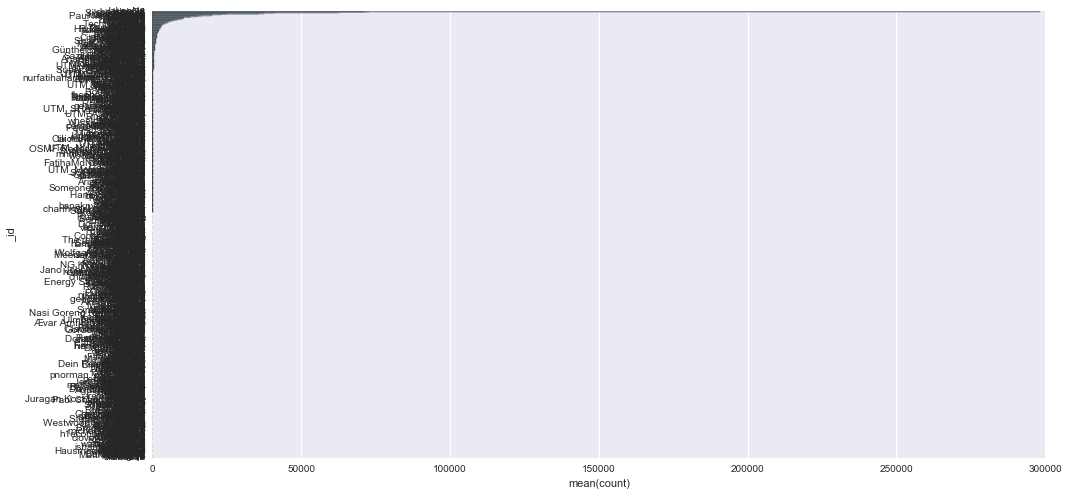

In [13]:
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Number of unique users
print "Number of unique users:", len(list(sg.distinct("user")))

# Number of contribution per user
users = DataFrame(list( \
            sg.aggregate([{"$group" : {"_id" : "$user", \
                                       "count" : {"$sum" : 1}}}, \
                          {"$sort" : {"count" : -1}}])))
# Barplot of user contribution
%matplotlib inline
plt.figure(figsize=(16, 8))
_ = sns.barplot(x="count", y="_id", data=users, orient="h", color="lightblue")

The distribution of user contribution is highly skewed and it's hard to read the graph. So let's use log scale. By the way, please ignore unreadable y-axis labels that express user names. Here each individual user name does not really matter.

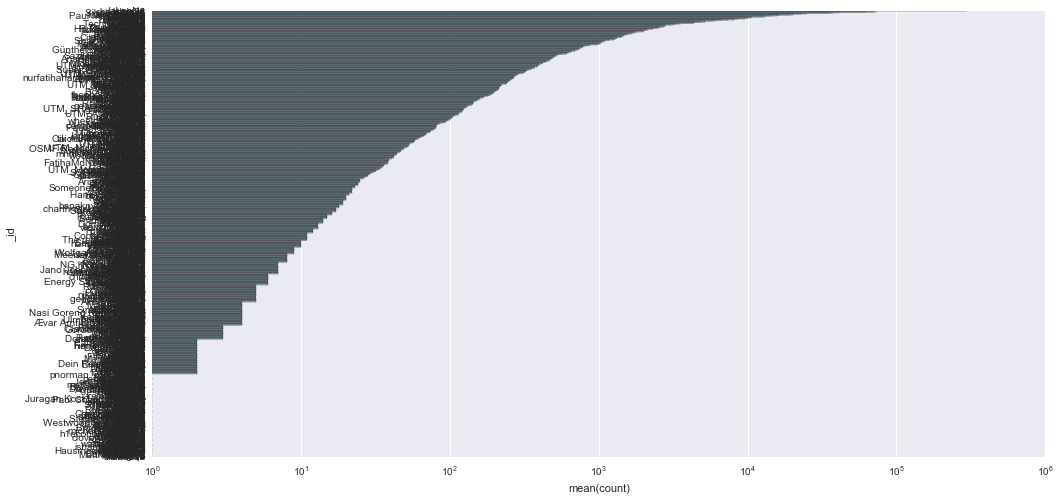

In [15]:
plt.figure(figsize=(16, 8))
_ = sns.barplot(x="count", y="_id", data=users, orient="h", color="lightblue", log=True)

OK, it looks prettier. Roughly speaking, a half of uses contributed less than 10 times and the half (which means one forth) contributed just once. (1 becomes 0 in log scale so no bar means 1.)

By looking at *timestamp* field, we can know when the element was registered or updated. 

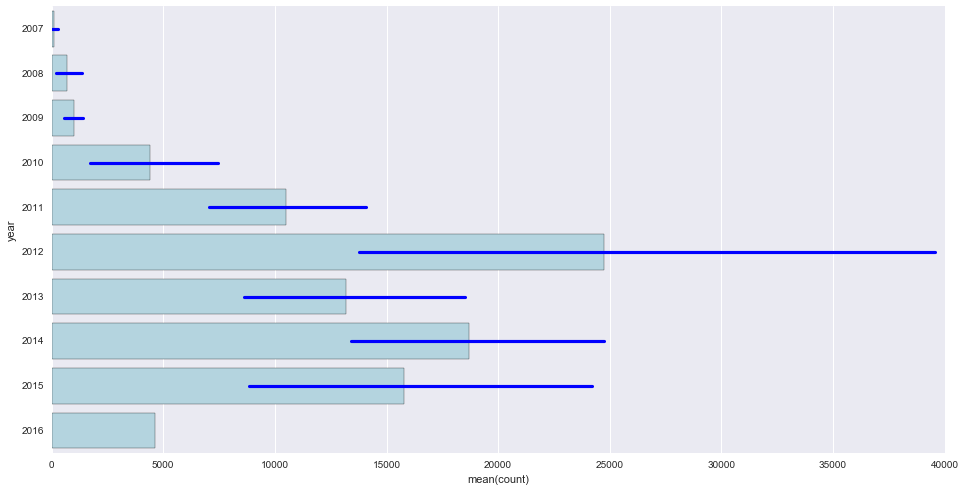

In [17]:
# When was each element registered or updated?
# (Aggregattion by year and month of timestamp)
history = DataFrame(list( \
             sg.aggregate([{"$match" : {"$or" : [{"xml" : "node"}, \
                                                 {"xml" : "relation"}, \
                                                 {"xml" : "way"}]}}, \
                           {"$group" : {"_id" : {"year" : {"$year" : "$timestamp"}, \
                                                 "month" : {"$month" : "$timestamp"}}, \
                                       "count" : {"$sum" : 1}}}, 
                           {"$project" : {"year" : "$_id.year",
                                          "month" : "$_id.month",
                                          "_id" : 0, 
                                          "count" : 1}}, \
                           {"$sort" : {"month" : 1, 
                                       "year" : 1}}])))
# Barplot of the change history
plt.figure(figsize=(16, 8))
_ = sns.barplot(x="count", y="year", data=history, orient="h", color="lightblue", errcolor="blue")

The chart above shows the mean of count of data registration and update in a month. A blue lines on each bar expresses 95% confidence interval of the distribution, in short, the longer a blue line gets, the bigger variance is.

Each *node* element has a location, namely longitude and latitude. So if it's prejected on a map coordinate, we can see which part of the country has more data.

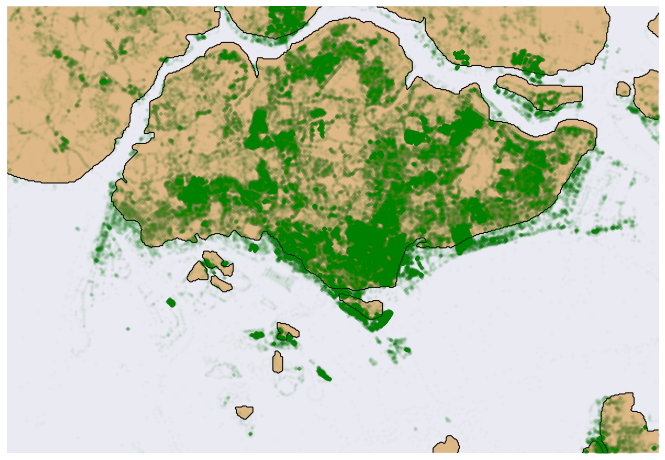

In [20]:
from mpl_toolkits.basemap import Basemap

# Get the map coordinate from bounds tag
bounds = sg.find_one({"xml" : "bounds"})
# Create ajustment terms for the map coordinate
lon_ajst = (bounds["maxlon"] - bounds["minlon"]) / 3
lat_ajst = (bounds["maxlat"] - bounds["minlat"]) / 3
# Get longitude and latitude from node tags
node = DataFrame(list(sg.aggregate([{"$match" : {"xml" : "node"}}, \
                                    {"$project" : {"lat" : 1, "lon" : 1}}])))

# Project node location (longitude / latitude) on map
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', resolution="f", 
            llcrnrlon=bounds["minlon"]+lon_ajst, llcrnrlat=bounds["minlat"]+lat_ajst,
            urcrnrlon=bounds["maxlon"]-lon_ajst, urcrnrlat=bounds["maxlat"]-lat_ajst)
m.drawcoastlines()
m.fillcontinents(color='burlywood')
xpt, ypt = m(list(node["lon"]), list(node["lat"]))
m.plot(xpt, ypt, 'g.', alpha=0.01)
plt.show()

Each data point is plotted as a transparent green dot so that deeper green is seen in dense areas. By comparing it to the [actual map](https://www.openstreetmap.org/node/531668011#map=11/1.3237/103.8778), it is clear that dark green is located along with the main roads. Also it is noticed that some reclaimed lands are not shown on the map. (ex. Changi airport at the end of east coast.)

To make the density clearer, another plot is created as follows.

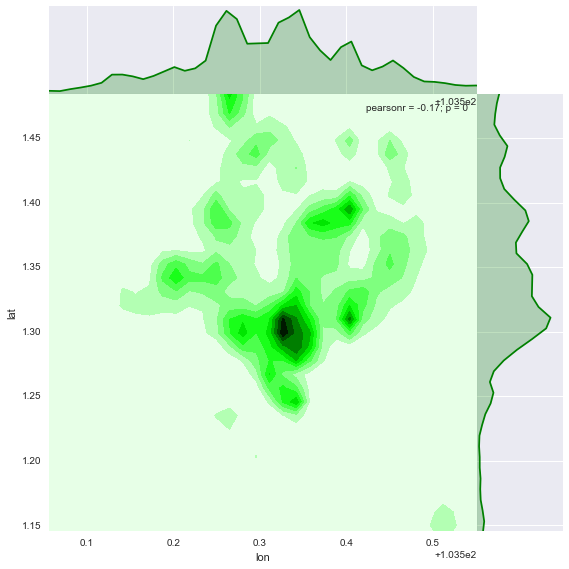

In [23]:
# Jointplot of location
_ = sns.jointplot(x="lon", y="lat", data=node, kind="kde", space=0, color="g", size=8, \
                  xlim=(bounds["minlon"]+lon_ajst, bounds["maxlon"]-lon_ajst), \
                  ylim=(bounds["minlat"]+lat_ajst, bounds["maxlat"]-lat_ajst))

From the density plot it is clear that the center of the city is the densest area. (The joint plot above has to be a square so that the width of figure got slimmed as compared to the first map projection.)

## 7. Summary
Through visual check on some aggregated data several quality issues were noticed and modified. The data cleansing was done programmatically though, it still contained not a few heuristic, arbitrary aproaches. To aim cleaner and higher quality, it is hoped that more abstract, higher level questions should be considered in the future project.  
- What factor creates inconsistent expressions where data actually means the same? 
- How can the idea of inconsintency detection be expanded to cover as many string fields as possible?
- Is there any way to utilize other fields to modify a certain field? (ex. Is it possible to modify postal code based on the longitude and latitude?)

If these questions are sufficiently answered and implemented in a programmatc manner in the cleansing process, inconsistencies in the data set would be reduced and higher quality data will be provided to the subsequent phase or project. But, at the same time it can be said that asking more abstract questions is difficult and never ends. So to reach a suffucient quality level in a practical time period, it would be more realistic to start with defining the subsequent phase first. Knowing the purpose of data usage enables us to ask more concrete questions and make it easier to reach a quality level required.

## 8. Future Projects
As mentioned in the previous section, there are still not a few things that we can do to improve the quality of OSM data. To be specific, I'd like to suggest the following for future projects.

[Suggestion 1]  
To detect strings that have the same meaning in different expressions, develop statistical models which estimate similarity of strings. This is an application of machine learning algorithms to measure similarity and many common non-linear classification algorithms, like K-Nearest Neighbors, Support Vector Machine, Locality-Sensitive Hashing, etc can be used. The approach is very programmatic and general so that the possible application area is broad. On the other hand, if we pursue a highly accurate model, defining a type of "dictionary" is necessary to measure semantic similarities. It would still require a big heuristic effort if there isn't an existing dictionary for the same purpose.

[Suggestion 2]  
To make postal codes more accurate, utilize other Web APIs which provide address data by receiving longitude and latitude. Since each *node* element has its longitude and latitude, it can be performed programmatically. One of the strongest candidates for this is [Google Map Reverse Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro#ReverseGeocoding). This approach highly depends on the quality of data other Web APIs provide. So the question we have to ask is "How can we assure the data quality from other Web APIs?". One posibble mitigation is to use several APIs for each location and determine the correct one by voting scheme.

## 9. Reference
* 7.2. re — Regular expression operations, Python 2.7.11 Documentation - https://docs.python.org/2/library/re.html
* Regular Expression HOWTO, Python 2.7.11 Documentation - https://docs.python.org/2/howto/regex.html
* '8. Errors and Exceptions, Python 2.7.11 Documentation - https://docs.python.org/2/tutorial/errors.html
* 8.1. datetime — Basic date and time types, Python 2.7.11 Documentation - https://docs.python.org/2/library/datetime.html
* 18.2. json — JSON encoder and decoder, Python 2.7.11 Documentation - https://docs.python.org/2/library/json.html
* 19.7. xml.etree.ElementTree — The ElementTree XML API, Python 2.7.11 Documentation - https://docs.python.org/2/library/xml.etree.elementtree.html
* API Documentation, PyMongo 3.2 documentation - https://api.mongodb.org/python/current/api/index.html
* Tutorial, PyMongo 3.2 documentation - https://api.mongodb.org/python/current/tutorial.html
* Examples, PyMongo 3.2 documentation - https://api.mongodb.org/python/current/examples/index.html
* Query and Projection Operators, MongoDB Manual 3.2 - https://docs.mongodb.org/manual/reference/operator/query/
* Aggregation Pipeline Operators, MongoDB Manual 3.2 - https://docs.mongodb.org/manual/reference/operator/aggregation/
* PEP 0008 -- Style Guide for Python Code - https://www.python.org/dev/peps/pep-0008/
* PEP 0257 -- Docstring Conventions - https://www.python.org/dev/peps/pep-0257/
* Google Python Style Guide - http://google.github.io/styleguide/pyguide.html
* API reference, seaborn 0.6.0 - http://stanford.edu/~mwaskom/software/seaborn/api.html
* Matplotlib Basemap Toolkit documentation - http://matplotlib.org/basemap/
* Simple maps in Python, Nancy Soontiens - https://github.com/BillMills/python-mapping
* Plotting with seaborn using the matplotlib object-oriented interface, stackoverflow - http://stackoverflow.com/questions/23969619/plotting-with-seaborn-using-the-matplotlib-object-oriented-interface
* OSM XML Wiki - https://wiki.openstreetmap.org/wiki/OSM_XML
* Get location address from Latitude and Longitude in google maps, stackoverflow - http://stackoverflow.com/questions/14051106/get-location-address-from-latitude-and-longitude-in-google-maps
* Reverse Geocoding (Address Lookup), The Google Maps Geocoding API - https://developers.google.com/maps/documentation/geocoding/intro#ReverseGeocoding